# Residuals Networks and Transfer Learning


In this notebook we are going to implement a simple convolutional neural network as well as CNN with residual connections. Additionally we will also take a look at Transfer Learning.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharifiZarchi/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/ResNets_Transfer_Learning.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/SharifiZarchi/Introduction_to_Machine_Learning/main/Jupyter_Notebooks/Chapter_04_Computer_Vision/ResNets_Transfer_Learning.ipynb)

In [ ]:
# @title setup and imports

from matplotlib import pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.cifar import CIFAR10

from torchsummary import summary

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# @title helper functions

def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.
    train_acc = 0.
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        train_acc += (logits.argmax(dim=1) == labels).sum().item()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader.dataset)
    return train_loss, train_acc


def validate_epoch(model, dataloader, loss_fn, device):
    model.eval()
    val_loss = 0.
    val_acc = 0.
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=1) == labels).sum().item()
        val_loss /= len(dataloader)
        val_acc /= len(dataloader.dataset)
    return val_loss, val_acc


def train_model(model, train_dataloader, val_dataloader, optimizer, n_epochs, device=device):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    loss_fn = CrossEntropyLoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(train_loss), history['train_acc'].append(train_acc)
        val_loss, val_acc = validate_epoch(model, val_dataloader, loss_fn, device)
        history['val_loss'].append(val_loss), history['val_acc'].append(val_acc)
        pbar.set_description(f'Training Accuracy {100 * train_acc:.2f}% | Validation Accuracy {100 * val_acc:.2f}% ')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='train')
    ax1.plot(history['val_loss'], label='val')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train')
    ax2.plot(history['val_acc'], label='val')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [ ]:
# @title CIFAR10 dataset

norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std),
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Convolutional Neural Networks

Let's start by creating `BasicBlock`s for the CNN. We will create our blocks as follows:


*   Each block will have 3 convolutional layers with `kernel_size=3` and `padding=1`
*   Each convolutional layer will be followed by a batch normalization layer and a `ReLU` activation function
*   At the end of each block, we will apply a max pooling layer to reduce the dimensions by a factor of 2



In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:

        super(BasicBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.block(x)
        return  out

Next we will proceed to the network itself. Using the `BasicBlock` module, we first create three blocks and double the number of channels at each one (except for the first block which has an output channel size of 64). At last we use an average pooling layer in addition to a fully connected layer to make the predictions.

In [ ]:
class Network(nn.Module):
    def __init__(self, img_channels: int = 3, num_classes: int = 10, block: nn.Module = BasicBlock) -> None:

        super(Network, self).__init__()

        self.block1 = block(img_channels, 64)
        self.block2 = block(64, 128)
        self.block3 = block(128, 256)
        self.block4 = block(256, 512)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Now lets create an instance of this architecture and see its parameter count.

In [ ]:
cnn = Network().to(device)
summary(cnn, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicBlock: 1-1                        [-1, 64, 16, 16]          --
|    └─Sequential: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-8             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-9                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-10                 [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-11            [-1, 64, 32, 32]          

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicBlock: 1-1                        [-1, 64, 16, 16]          --
|    └─Sequential: 2-1                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-8             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-9                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-10                 [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-11            [-1, 64, 32, 32]          

Finally we can train our model.

Training Accuracy 95.18% | Validation Accuracy 89.33% : 100%|██████████| 30/30 [17:29<00:00, 34.99s/it]


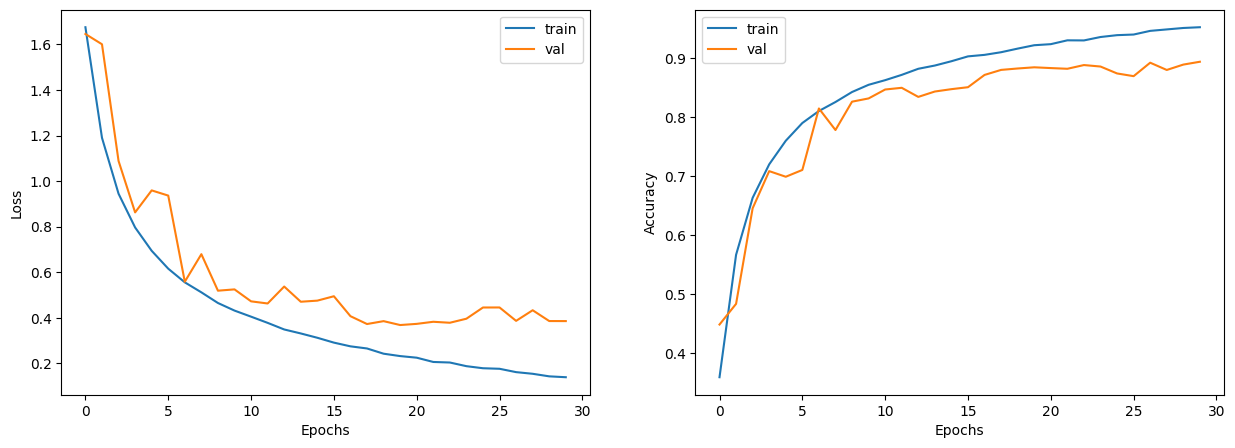

In [ ]:
if device == 'cuda':
    cnn = torch.compile(cnn)
optim = Adam(cnn.parameters(), lr=1e-3)

results = train_model(cnn, trainloader, testloader, optim, n_epochs=30)
plot_history(results)

# Residual Networks

In this section we are going to implement CNNs with residual connections. To do so we will first implement a `ResidualBlock` module. In each block we must first apply a convolutional layer so that the `in_channels` and `out_channels` match. We will keep a copy of the output of this convolutional layer and add it to the output of the next two convolutions. After that we can apply a max pooling layer to reduce the dimensions of the input.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:

        super(ResidualBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        self.block = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = self.conv(x)
        out = self.block(identity) + identity
        out = self.downsample(out)
        return  out

Using the `ResidualBlock` module we just defined and the `Network` module from the previous section, we can now build a residual network.

In [ ]:
resnet = Network(block=ResidualBlock).to(device)
summary(resnet, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResidualBlock: 1-1                     [-1, 64, 16, 16]          --
|    └─Sequential: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-8             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-9                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-10                 [-1, 64, 32, 32]          36,9

Layer (type:depth-idx)                   Output Shape              Param #
├─ResidualBlock: 1-1                     [-1, 64, 16, 16]          --
|    └─Sequential: 2-1                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          1,792
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    └─Sequential: 2-2                   [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 64, 32, 32]          36,928
|    |    └─BatchNorm2d: 3-8             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-9                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-10                 [-1, 64, 32, 32]          36,9

Training Accuracy 97.21% | Validation Accuracy 90.17% : 100%|██████████| 30/30 [17:49<00:00, 35.64s/it]


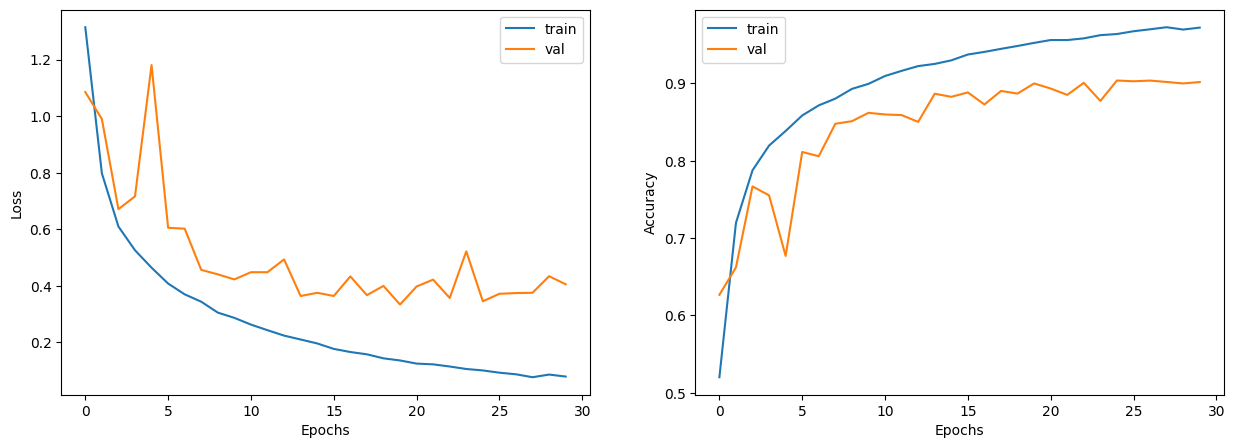

In [ ]:
if device == 'cuda':
    resnet = torch.compile(resnet)
optim = Adam(resnet.parameters(), lr=1e-3)

results = train_model(resnet, trainloader, testloader, optim, n_epochs=30)
plot_history(results)

As you can see both networks are identical except for the residual connections. Even for small networks such as these two you can see the improvement due to the residual connections. For larger networks with 50, 100, etc layers, this gap in performance will become wider.

# Transfer Learning

In this section we are going to learn about transfer learning.

We use models available from torchvision. You can find a list of all [available models and pre-trained weights](https://pytorch.org/vision/stable/models.html) on torchvision.

To observe the improvement caused by transfer learning, we train the `ResNet18` model twice, once with pre-trained weights (from the ImageNet dataset) and once without pre-training.

In [ ]:
resnet18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

resnet18 = resnet18.to(device)
summary(resnet18, (3, 32, 32))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 16, 16]          128
├─ReLU: 1-3                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [-1, 64, 8, 8]            --
├─Sequential: 1-5                        [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-1                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-6                    [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-2                   [-1, 64, 8, 8]            --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 16, 16]          128
├─ReLU: 1-3                              [-1, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [-1, 64, 8, 8]            --
├─Sequential: 1-5                        [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-1                   [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-1                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-3                    [-1, 64, 8, 8]            --
|    |    └─Conv2d: 3-4                  [-1, 64, 8, 8]            36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 8, 8]            128
|    |    └─ReLU: 3-6                    [-1, 64, 8, 8]            --
|    └─BasicBlock: 2-2                   [-1, 64, 8, 8]            --
|

## Pre-Trained ResNet18

Training Accuracy 85.13% | Validation Accuracy 83.93% : 100%|██████████| 10/10 [02:46<00:00, 16.61s/it]


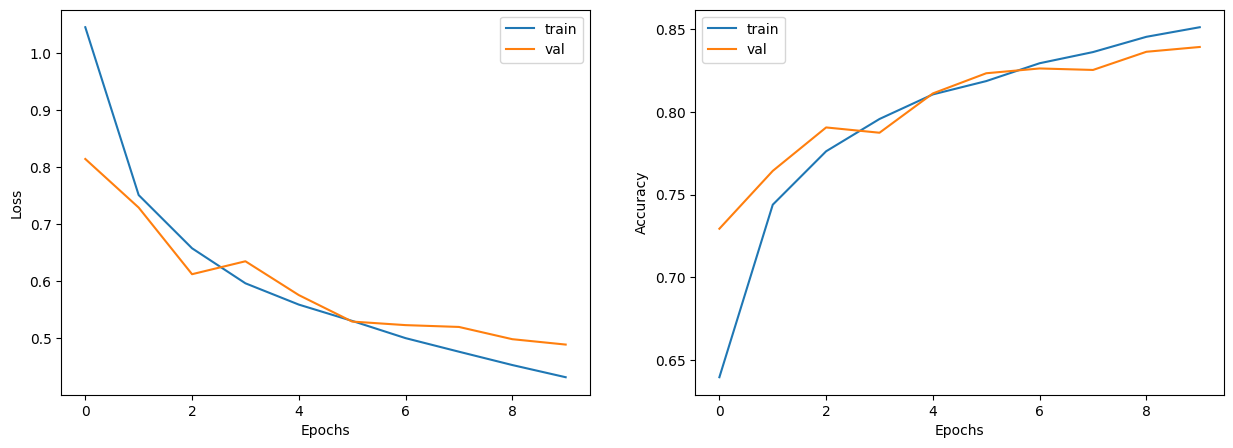

In [ ]:
if device == 'cuda':
    resnet18 = torch.compile(resnet18)
optim = Adam(resnet18.parameters(), lr=1e-3)

results = train_model(resnet18, trainloader, testloader, optim, n_epochs=10)
plot_history(results)

## Normal ResNet18

Training Accuracy 77.88% | Validation Accuracy 76.85% : 100%|██████████| 10/10 [02:43<00:00, 16.32s/it]


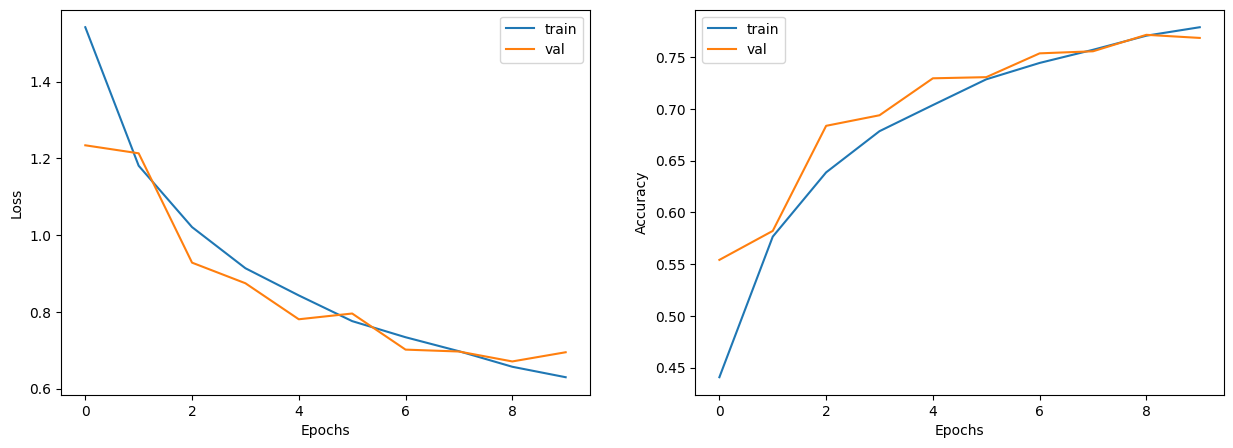

In [ ]:
resnet18 = models.resnet18(weights=None)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

resnet18 = resnet18.to(device)
if device == 'cuda':
    resnet18 = torch.compile(resnet18)
optim = Adam(resnet18.parameters(), lr=1e-3)

results = train_model(resnet18, trainloader, testloader, optim, n_epochs=10)
plot_history(results)

## Results

As you can see the pre-trained weights improve the accuracy significantly.

# Refrences

*   [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
*   [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

